# HAR LSTM training 

In [1]:
# HAR classification 
# Author: Burak Himmetoglu
# 8/15/2017

import pandas as pd 
import numpy as np
import os

def read_data(data_path, split = "train"):
	""" Read data """

	# Fixed params
	n_class = 6
	n_steps = 128

	# Paths
	path_ = os.path.join(data_path, split)
	path_signals = os.path.join(path_, "Inertial_Signals")

	# Read labels and one-hot encode
	label_path = os.path.join(path_, "y_" + split + ".txt")
	labels = pd.read_csv(label_path, header = None)

	# Read time-series data
	channel_files = os.listdir(path_signals)
	channel_files.sort()
	n_channels = len(channel_files)
	posix = len(split) + 5

	# Initiate array
	list_of_channels = []
	X = np.zeros((len(labels), n_steps, n_channels))
	i_ch = 0
	for fil_ch in channel_files:
		channel_name = fil_ch[:-posix]
		dat_ = pd.read_csv(os.path.join(path_signals,fil_ch), delim_whitespace = True, header = None)
		X[:,:,i_ch] = dat_.as_matrix()

		# Record names
		list_of_channels.append(channel_name)

		# iterate
		i_ch += 1

	# Return 
	return X, labels[0].values, list_of_channels

# How to normalize the input data correctly
def standardize(train, test):
	""" Standardize data """
	# Standardize train and test
	X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
	X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]
	return X_train, X_test

# How to onehot-encoding
# def one_hot(labels, n_class = 6):
# 	""" One-hot encoding """
# 	expansion = np.eye(n_class)
# 	y = expansion[:, labels-1].T
# 	assert y.shape[1] == n_class, "Wrong number of labels!"
# 	return y

def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]

## Prepare data: Traing/Test data

In [2]:
Xtrain, Ytrain, list_ch_train = read_data(data_path="/home/arasdar/datasets/har-data/", split="train") # train
Xtest, Ytest, list_ch_test = read_data(data_path="/home/arasdar/datasets/har-data/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [3]:
Xtrain, Xtest = standardize(test=Xtest, train=Xtrain)

# Train/Validation Split

In [4]:
from sklearn.model_selection import train_test_split

Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtrain, Ytrain, stratify = Ytrain, random_state = 123)

In [5]:
print(Xtrain.shape, Xtrain.dtype)
print(Xvalid.shape, Xvalid.dtype)
print(Xtest.shape, Xtest.dtype)
print(Ytrain.shape, Ytrain.dtype, Ytrain.max(), Ytrain.min())
print(Yvalid.shape, Yvalid.dtype, Yvalid.max(), Yvalid.min())
print(Ytest.shape, Ytest.dtype, Ytest.max(), Ytest.min())

(5514, 128, 9) float64
(1838, 128, 9) float64
(2947, 128, 9) float64
(5514,) int64 6 1
(1838,) int64 6 1
(2947,) int64 6 1


### Hyperparameters

In [6]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


In [22]:
# Hyperparameters
lstm_size = 27         # 3 times the amount of channels
lstm_layers = 1        # Number of layers
batch_size = 256       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.001  # Learning rate (default is 0.001)
epochs = 1000

# Fixed
n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [23]:
# graph = tf.Graph()

# Construct placeholders
# with graph.as_default():
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
indices_ = tf.placeholder(tf.int32, [None], name = 'indices')
# keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
# learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM

In [24]:
# with graph.as_default():
# Construct the LSTM inputs and LSTM cells
print(inputs_.shape)
lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
print(lstm_in.shape)
lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
print(lstm_in.shape)

# Open up the tensor into a list of seq_len pieces
lstm_in = tf.split(lstm_in, seq_len, 0)
print(len(lstm_in), lstm_in[0].shape)

# Add LSTM layers
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
#     drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
cell = tf.contrib.rnn.MultiRNNCell([lstm] * lstm_layers)
initial_state = cell.zero_state(batch_size, tf.float32)

(?, 128, 9)
(128, ?, 9)
(?, 9)
128 (?, 9)


Define forward pass, cost function and optimizer:

In [25]:
# with graph.as_default():
# with tf.variable_scope('RNN', reuse=True):
outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32, initial_state = initial_state)

# We only need the last output tensor to pass into a classifier
logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
labels = tf.one_hot(depth=n_classes, indices=indices_)

# Loss/cost using labels and logits
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))

# Accuracy using logits and labels
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

# Optimize using loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) # No grad clipping

ValueError: Variable rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-10-09723a368595>", line 3, in <module>
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32, initial_state = initial_state)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):


In [11]:
print(len(outputs), outputs[0].shape)

128 (2947, 27)


In [12]:
print(cost)

Tensor("Mean:0", shape=(), dtype=float32)


In [13]:
print(logits)

Tensor("logits/BiasAdd:0", shape=(2947, 6), dtype=float32)


### Train the network

In [14]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [15]:
valid_acc, valid_loss = [], []
train_acc, train_loss = [], []

# with graph.as_default():
saver = tf.train.Saver()

with tf.Session() as sess:
    # Initialize the global variable instead of loading them or if there is nothing to load.
    sess.run(tf.global_variables_initializer())
    
    #     # Restore
    #     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    #     saver.restore(sess,"checkpoints/har-lstm.ckpt")
    
    # Epochs/episodes of training/updating the model/network
    for e in range(epochs):
        
        # Training: Loop over batches
        state = sess.run(initial_state)
        acc_batch, loss_batch = [], []
        for Xbatch, Ybatch in get_batches(Xtrain, Ytrain, batch_size):

            # Feed dictionary
            feed_dict = {inputs_: Xbatch, indices_: Ybatch, initial_state: state}
            loss, _, state, acc = sess.run([cost, optimizer, final_state, accuracy], feed_dict)
            acc_batch.append(acc)
            loss_batch.append(loss)

        # Print at each epoch/iteration
        print("Training Epoch: {}/{}".format(e+1, epochs),
              "loss:{:.4f}".format(np.mean(loss_batch)),
              "acc:{:.4f}".format(np.mean(acc_batch)))

        # Store at each epoch/iteration
        train_loss.append(np.mean(loss_batch))
        train_acc.append(np.mean(acc_batch))
        
        # Validation: Loop over batches
        state = sess.run(initial_state)
        acc_batch, loss_batch = [], []
        for Xbatch, Ybatch in get_batches(Xvalid, Yvalid, batch_size):

            # Feed dictionary
            feed_dict = {inputs_: Xbatch, indices_: Ybatch, initial_state: state}
            loss, state, acc = sess.run([cost, final_state, accuracy], feed_dict)
            acc_batch.append(acc)
            loss_batch.append(loss)

        # Print at each epoch/iteration
        print("Validation Epoch: {}/{}".format(e+1, epochs),
              "loss:{:.4f}".format(np.mean(loss_batch)),
              "acc:{:.4f}".format(np.mean(acc_batch)))

        # Store at each epoch/iteration
        valid_loss.append(np.mean(loss_batch))
        valid_acc.append(np.mean(acc_batch))
            
    saver.save(sess,"checkpoints/model.ckpt")

Training Epoch: 1/1000 loss:1.4527 acc:0.2046
Validation Epoch: 1/1000 loss:nan acc:nan
Training Epoch: 2/1000 loss:1.4461 acc:0.2348
Validation Epoch: 2/1000 loss:nan acc:nan
Training Epoch: 3/1000 loss:1.4395 acc:0.2647
Validation Epoch: 3/1000 loss:nan acc:nan


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training Epoch: 4/1000 loss:1.4330 acc:0.2891
Validation Epoch: 4/1000 loss:nan acc:nan
Training Epoch: 5/1000 loss:1.4264 acc:0.3088
Validation Epoch: 5/1000 loss:nan acc:nan
Training Epoch: 6/1000 loss:1.4199 acc:0.3234
Validation Epoch: 6/1000 loss:nan acc:nan
Training Epoch: 7/1000 loss:1.4134 acc:0.3349
Validation Epoch: 7/1000 loss:nan acc:nan
Training Epoch: 8/1000 loss:1.4070 acc:0.3441
Validation Epoch: 8/1000 loss:nan acc:nan
Training Epoch: 9/1000 loss:1.4004 acc:0.3492
Validation Epoch: 9/1000 loss:nan acc:nan
Training Epoch: 10/1000 loss:1.3939 acc:0.3553
Validation Epoch: 10/1000 loss:nan acc:nan
Training Epoch: 11/1000 loss:1.3873 acc:0.3590
Validation Epoch: 11/1000 loss:nan acc:nan
Training Epoch: 12/1000 loss:1.3807 acc:0.3631
Validation Epoch: 12/1000 loss:nan acc:nan
Training Epoch: 13/1000 loss:1.3740 acc:0.3655
Validation Epoch: 13/1000 loss:nan acc:nan
Training Epoch: 14/1000 loss:1.3672 acc:0.3685
Validation Epoch: 14/1000 loss:nan acc:nan
Training Epoch: 15/100

Training Epoch: 96/1000 loss:0.7313 acc:0.5531
Validation Epoch: 96/1000 loss:nan acc:nan
Training Epoch: 97/1000 loss:0.7289 acc:0.5548
Validation Epoch: 97/1000 loss:nan acc:nan
Training Epoch: 98/1000 loss:0.7262 acc:0.5568
Validation Epoch: 98/1000 loss:nan acc:nan
Training Epoch: 99/1000 loss:0.7235 acc:0.5575
Validation Epoch: 99/1000 loss:nan acc:nan
Training Epoch: 100/1000 loss:0.7208 acc:0.5582
Validation Epoch: 100/1000 loss:nan acc:nan
Training Epoch: 101/1000 loss:0.7181 acc:0.5596
Validation Epoch: 101/1000 loss:nan acc:nan
Training Epoch: 102/1000 loss:0.7150 acc:0.5612
Validation Epoch: 102/1000 loss:nan acc:nan
Training Epoch: 103/1000 loss:0.7121 acc:0.5619
Validation Epoch: 103/1000 loss:nan acc:nan
Training Epoch: 104/1000 loss:0.7094 acc:0.5633
Validation Epoch: 104/1000 loss:nan acc:nan
Training Epoch: 105/1000 loss:0.7066 acc:0.5633
Validation Epoch: 105/1000 loss:nan acc:nan
Training Epoch: 106/1000 loss:0.7039 acc:0.5636
Validation Epoch: 106/1000 loss:nan acc:

Training Epoch: 186/1000 loss:0.4376 acc:0.7109
Validation Epoch: 186/1000 loss:nan acc:nan
Training Epoch: 187/1000 loss:0.4330 acc:0.7156
Validation Epoch: 187/1000 loss:nan acc:nan
Training Epoch: 188/1000 loss:0.4279 acc:0.7184
Validation Epoch: 188/1000 loss:nan acc:nan
Training Epoch: 189/1000 loss:0.4224 acc:0.7194
Validation Epoch: 189/1000 loss:nan acc:nan
Training Epoch: 190/1000 loss:0.4182 acc:0.7211
Validation Epoch: 190/1000 loss:nan acc:nan
Training Epoch: 191/1000 loss:0.4151 acc:0.7218
Validation Epoch: 191/1000 loss:nan acc:nan
Training Epoch: 192/1000 loss:0.4119 acc:0.7251
Validation Epoch: 192/1000 loss:nan acc:nan
Training Epoch: 193/1000 loss:0.4091 acc:0.7268
Validation Epoch: 193/1000 loss:nan acc:nan
Training Epoch: 194/1000 loss:0.4043 acc:0.7272
Validation Epoch: 194/1000 loss:nan acc:nan
Training Epoch: 195/1000 loss:0.3994 acc:0.7299
Validation Epoch: 195/1000 loss:nan acc:nan
Training Epoch: 196/1000 loss:0.3947 acc:0.7323
Validation Epoch: 196/1000 loss:

Training Epoch: 278/1000 loss:0.2793 acc:0.7462
Validation Epoch: 278/1000 loss:nan acc:nan
Training Epoch: 279/1000 loss:0.2792 acc:0.7472
Validation Epoch: 279/1000 loss:nan acc:nan
Training Epoch: 280/1000 loss:0.2776 acc:0.7479
Validation Epoch: 280/1000 loss:nan acc:nan
Training Epoch: 281/1000 loss:0.2759 acc:0.7479
Validation Epoch: 281/1000 loss:nan acc:nan
Training Epoch: 282/1000 loss:0.2737 acc:0.7479
Validation Epoch: 282/1000 loss:nan acc:nan
Training Epoch: 283/1000 loss:0.2718 acc:0.7486
Validation Epoch: 283/1000 loss:nan acc:nan
Training Epoch: 284/1000 loss:0.2702 acc:0.7496
Validation Epoch: 284/1000 loss:nan acc:nan
Training Epoch: 285/1000 loss:0.2663 acc:0.7513
Validation Epoch: 285/1000 loss:nan acc:nan
Training Epoch: 286/1000 loss:0.2652 acc:0.7509
Validation Epoch: 286/1000 loss:nan acc:nan
Training Epoch: 287/1000 loss:0.2634 acc:0.7503
Validation Epoch: 287/1000 loss:nan acc:nan
Training Epoch: 288/1000 loss:0.2634 acc:0.7499
Validation Epoch: 288/1000 loss:

Training Epoch: 368/1000 loss:0.2834 acc:0.7296
Validation Epoch: 368/1000 loss:nan acc:nan
Training Epoch: 369/1000 loss:0.2951 acc:0.7228
Validation Epoch: 369/1000 loss:nan acc:nan
Training Epoch: 370/1000 loss:0.3052 acc:0.7190
Validation Epoch: 370/1000 loss:nan acc:nan
Training Epoch: 371/1000 loss:0.3207 acc:0.7126
Validation Epoch: 371/1000 loss:nan acc:nan
Training Epoch: 372/1000 loss:0.3340 acc:0.7078
Validation Epoch: 372/1000 loss:nan acc:nan
Training Epoch: 373/1000 loss:0.3423 acc:0.7048
Validation Epoch: 373/1000 loss:nan acc:nan
Training Epoch: 374/1000 loss:0.3468 acc:0.7017
Validation Epoch: 374/1000 loss:nan acc:nan
Training Epoch: 375/1000 loss:0.3494 acc:0.7021
Validation Epoch: 375/1000 loss:nan acc:nan
Training Epoch: 376/1000 loss:0.3486 acc:0.7038
Validation Epoch: 376/1000 loss:nan acc:nan
Training Epoch: 377/1000 loss:0.3436 acc:0.7078
Validation Epoch: 377/1000 loss:nan acc:nan
Training Epoch: 378/1000 loss:0.3287 acc:0.7133
Validation Epoch: 378/1000 loss:

Training Epoch: 459/1000 loss:0.2290 acc:0.7509
Validation Epoch: 459/1000 loss:nan acc:nan
Training Epoch: 460/1000 loss:0.2287 acc:0.7516
Validation Epoch: 460/1000 loss:nan acc:nan
Training Epoch: 461/1000 loss:0.2285 acc:0.7516
Validation Epoch: 461/1000 loss:nan acc:nan
Training Epoch: 462/1000 loss:0.2282 acc:0.7516
Validation Epoch: 462/1000 loss:nan acc:nan
Training Epoch: 463/1000 loss:0.2279 acc:0.7516
Validation Epoch: 463/1000 loss:nan acc:nan
Training Epoch: 464/1000 loss:0.2276 acc:0.7513
Validation Epoch: 464/1000 loss:nan acc:nan
Training Epoch: 465/1000 loss:0.2270 acc:0.7513
Validation Epoch: 465/1000 loss:nan acc:nan
Training Epoch: 466/1000 loss:0.2263 acc:0.7516
Validation Epoch: 466/1000 loss:nan acc:nan
Training Epoch: 467/1000 loss:0.2261 acc:0.7516
Validation Epoch: 467/1000 loss:nan acc:nan
Training Epoch: 468/1000 loss:0.2258 acc:0.7516
Validation Epoch: 468/1000 loss:nan acc:nan
Training Epoch: 469/1000 loss:0.2259 acc:0.7513
Validation Epoch: 469/1000 loss:

Training Epoch: 549/1000 loss:0.2208 acc:0.7540
Validation Epoch: 549/1000 loss:nan acc:nan
Training Epoch: 550/1000 loss:0.2204 acc:0.7540
Validation Epoch: 550/1000 loss:nan acc:nan
Training Epoch: 551/1000 loss:0.2198 acc:0.7543
Validation Epoch: 551/1000 loss:nan acc:nan
Training Epoch: 552/1000 loss:0.2196 acc:0.7543
Validation Epoch: 552/1000 loss:nan acc:nan
Training Epoch: 553/1000 loss:0.2193 acc:0.7553
Validation Epoch: 553/1000 loss:nan acc:nan
Training Epoch: 554/1000 loss:0.2188 acc:0.7550
Validation Epoch: 554/1000 loss:nan acc:nan
Training Epoch: 555/1000 loss:0.2181 acc:0.7553
Validation Epoch: 555/1000 loss:nan acc:nan
Training Epoch: 556/1000 loss:0.2180 acc:0.7533
Validation Epoch: 556/1000 loss:nan acc:nan
Training Epoch: 557/1000 loss:0.2179 acc:0.7536
Validation Epoch: 557/1000 loss:nan acc:nan
Training Epoch: 558/1000 loss:0.2178 acc:0.7533
Validation Epoch: 558/1000 loss:nan acc:nan
Training Epoch: 559/1000 loss:0.2174 acc:0.7533
Validation Epoch: 559/1000 loss:

Training Epoch: 639/1000 loss:0.2006 acc:0.7553
Validation Epoch: 639/1000 loss:nan acc:nan
Training Epoch: 640/1000 loss:0.2008 acc:0.7547
Validation Epoch: 640/1000 loss:nan acc:nan
Training Epoch: 641/1000 loss:0.2012 acc:0.7547
Validation Epoch: 641/1000 loss:nan acc:nan
Training Epoch: 642/1000 loss:0.2030 acc:0.7536
Validation Epoch: 642/1000 loss:nan acc:nan
Training Epoch: 643/1000 loss:0.2028 acc:0.7536
Validation Epoch: 643/1000 loss:nan acc:nan
Training Epoch: 644/1000 loss:0.2028 acc:0.7533
Validation Epoch: 644/1000 loss:nan acc:nan
Training Epoch: 645/1000 loss:0.2026 acc:0.7543
Validation Epoch: 645/1000 loss:nan acc:nan
Training Epoch: 646/1000 loss:0.2024 acc:0.7547
Validation Epoch: 646/1000 loss:nan acc:nan
Training Epoch: 647/1000 loss:0.2021 acc:0.7550
Validation Epoch: 647/1000 loss:nan acc:nan
Training Epoch: 648/1000 loss:0.2017 acc:0.7557
Validation Epoch: 648/1000 loss:nan acc:nan
Training Epoch: 649/1000 loss:0.2013 acc:0.7553
Validation Epoch: 649/1000 loss:

Training Epoch: 729/1000 loss:0.1867 acc:0.7581
Validation Epoch: 729/1000 loss:nan acc:nan
Training Epoch: 730/1000 loss:0.1871 acc:0.7581
Validation Epoch: 730/1000 loss:nan acc:nan
Training Epoch: 731/1000 loss:0.1876 acc:0.7577
Validation Epoch: 731/1000 loss:nan acc:nan
Training Epoch: 732/1000 loss:0.1869 acc:0.7577
Validation Epoch: 732/1000 loss:nan acc:nan
Training Epoch: 733/1000 loss:0.1866 acc:0.7577
Validation Epoch: 733/1000 loss:nan acc:nan
Training Epoch: 734/1000 loss:0.1861 acc:0.7577
Validation Epoch: 734/1000 loss:nan acc:nan
Training Epoch: 735/1000 loss:0.1854 acc:0.7584
Validation Epoch: 735/1000 loss:nan acc:nan
Training Epoch: 736/1000 loss:0.1852 acc:0.7584
Validation Epoch: 736/1000 loss:nan acc:nan
Training Epoch: 737/1000 loss:0.1851 acc:0.7587
Validation Epoch: 737/1000 loss:nan acc:nan
Training Epoch: 738/1000 loss:0.1851 acc:0.7581
Validation Epoch: 738/1000 loss:nan acc:nan
Training Epoch: 739/1000 loss:0.1851 acc:0.7584
Validation Epoch: 739/1000 loss:

Training Epoch: 821/1000 loss:0.1742 acc:0.7611
Validation Epoch: 821/1000 loss:nan acc:nan
Training Epoch: 822/1000 loss:0.1739 acc:0.7615
Validation Epoch: 822/1000 loss:nan acc:nan
Training Epoch: 823/1000 loss:0.1738 acc:0.7618
Validation Epoch: 823/1000 loss:nan acc:nan
Training Epoch: 824/1000 loss:0.1738 acc:0.7618
Validation Epoch: 824/1000 loss:nan acc:nan
Training Epoch: 825/1000 loss:0.1734 acc:0.7611
Validation Epoch: 825/1000 loss:nan acc:nan
Training Epoch: 826/1000 loss:0.1732 acc:0.7611
Validation Epoch: 826/1000 loss:nan acc:nan
Training Epoch: 827/1000 loss:0.1718 acc:0.7618
Validation Epoch: 827/1000 loss:nan acc:nan
Training Epoch: 828/1000 loss:0.1717 acc:0.7621
Validation Epoch: 828/1000 loss:nan acc:nan
Training Epoch: 829/1000 loss:0.1710 acc:0.7621
Validation Epoch: 829/1000 loss:nan acc:nan
Training Epoch: 830/1000 loss:0.1708 acc:0.7611
Validation Epoch: 830/1000 loss:nan acc:nan
Training Epoch: 831/1000 loss:0.1707 acc:0.7611
Validation Epoch: 831/1000 loss:

Training Epoch: 912/1000 loss:0.1663 acc:0.7615
Validation Epoch: 912/1000 loss:nan acc:nan
Training Epoch: 913/1000 loss:0.1674 acc:0.7625
Validation Epoch: 913/1000 loss:nan acc:nan
Training Epoch: 914/1000 loss:0.1679 acc:0.7615
Validation Epoch: 914/1000 loss:nan acc:nan
Training Epoch: 915/1000 loss:0.1679 acc:0.7615
Validation Epoch: 915/1000 loss:nan acc:nan
Training Epoch: 916/1000 loss:0.1666 acc:0.7615
Validation Epoch: 916/1000 loss:nan acc:nan
Training Epoch: 917/1000 loss:0.1661 acc:0.7611
Validation Epoch: 917/1000 loss:nan acc:nan
Training Epoch: 918/1000 loss:0.1654 acc:0.7611
Validation Epoch: 918/1000 loss:nan acc:nan
Training Epoch: 919/1000 loss:0.1652 acc:0.7621
Validation Epoch: 919/1000 loss:nan acc:nan
Training Epoch: 920/1000 loss:0.1657 acc:0.7621
Validation Epoch: 920/1000 loss:nan acc:nan
Training Epoch: 921/1000 loss:0.1668 acc:0.7615
Validation Epoch: 921/1000 loss:nan acc:nan
Training Epoch: 922/1000 loss:0.1673 acc:0.7611
Validation Epoch: 922/1000 loss:

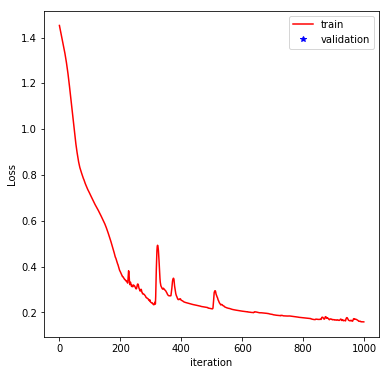

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training and test loss
plt.figure(figsize = (6,6))
plt.plot(np.array(train_loss), 'r-', np.array(valid_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

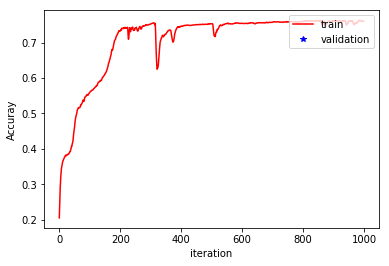

In [17]:
# Plot Accuracies
plt.plot(np.array(train_acc), 'r-', valid_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [18]:
loss, acc = [], []

with tf.Session() as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))

    # Testing: Loop over batches
    state = sess.run(initial_state)
    acc_batch, loss_batch = [], []
    for Xbatch, Ybatch in get_batches(Xtest, Ytest, batch_size):

        # Feed dictionary
        feed_dict = {inputs_: Xbatch, indices_: Ybatch, initial_state: state}
        loss, state, acc = sess.run([cost, final_state, accuracy], feed_dict)
        acc_batch.append(acc)
        loss_batch.append(loss)

    # Print at each epoch/iteration
    print("Epoch: {}/{}".format(e+1, epochs),
          "Test loss: {}".format(np.mean(loss_batch)),
          "Test acc: {}".format(np.mean(acc_batch)))

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
Epoch: 1000/1000 Test loss: 0.39789098501205444 Test acc: 0.6996946334838867
